## Problem Formulation: Estimating Group × Task Contribution Weights

### Objective

Estimate how much each **group** contributes to the **total time** of a task, allowing the contribution to vary across **task types**.  
We model **group-task interactions** explicitly, rather than assuming fixed group weights.

---

### Original (Simplified) Model

We previously assumed (in coefficient-estimation-group notebook):

$$
\text{TotalTime}_i = \sum_{g=1}^{G} \text{GroupCount}_{i,g} \cdot w_g + \epsilon_i
$$

- $i$: Task index  
- $g$: Group index  
- $w_g$: Time per unit count for each group (assumed fixed across all tasks)  
- Assumes that group contributions are the same for all tasks

---

###  Updated Model: Group × Task Interaction

We now estimate weights for each **group-task pair**:

$$
\text{TotalTime}_i = \sum_{g=1}^{G} \text{GroupCount}_{i,g} \cdot w_{g, t(i)} + \epsilon_i
$$

- $t(i)$: Task type for task $i$ (e.g., Task 1, Task 2, etc.)  
- $w_{g,t}$: Weight (time per unit) for Group $g$ on Task $t$  
- Captures the fact that groups may contribute differently depending on the task

---

### Implementation Approach

1. **Expand input features** into one column per `(Group, Task)` pair  
2. For each task, assign group counts to only the relevant interaction columns  
3. Fit a **linear regression model** (or constrained optimizer)  
4. Interpret the coefficients $w_{g,t}$ as **task-specific contribution rates per group**

---

### Advantages

- Accounts for task-specific effort differences  
- Improves interpretability when group roles vary across tasks  
- Better fits real-world data where teams perform differently depending on the task

---
### Notes

From the original notebook- coefficient-estimation, the new formulation has now expanded the feature space to include one variable per (Group, Task) combination. 
I think this is right from the conversation we had. Each task should have the same per group weighting. Whereas the other formulation was only calculating the weights per group and not considering the task.

- Using this dataset (multi-wp-full) we have 6 groups 4 taks and 24 unknowns. Whereas before with the original formulation you have 6 unknowns. 
- There is more variation in the features since you have group/ task interactions



## Import and process the data for modelling

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load your dataset
df = pd.read_csv("./data/underdetermined_multi_wp_full.csv")  # adjust path as needed

# Identify group columns and unique tasks
group_cols = [col for col in df.columns if col.startswith("Group")]
unique_tasks = df['Task'].unique()

# Create interaction features: one column per (Group, Task) pair
interaction_features = pd.DataFrame(0, index=df.index, columns=[
    f"{group}:{task}" for group in group_cols for task in unique_tasks
])

# Fill the interaction matrix
for idx, row in df.iterrows():
    for group in group_cols:
        task = row["Task"]
        interaction_features.at[idx, f"{group}:{task}"] = row[group]

# Define target variable
y = df["Total Time"]

## Plot data
 To help look at trends and distributions of the component data


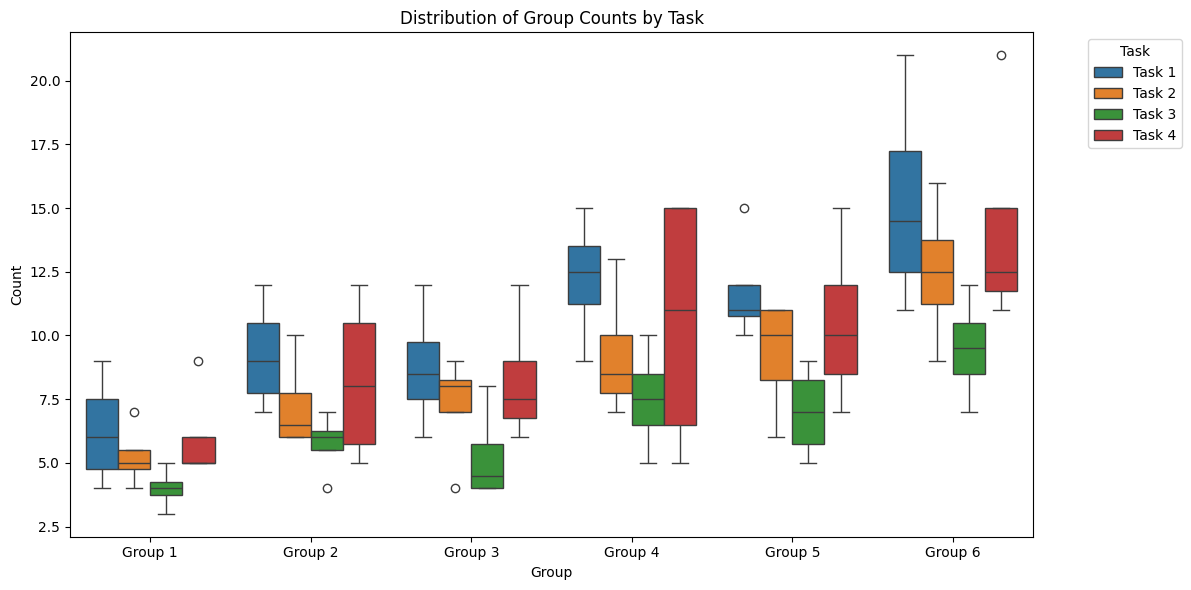

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the data to long format for seaborn
df_long = df.melt(
    id_vars=["Work Package", "Task", "Total Time"],
    value_vars=[col for col in df.columns if col.startswith("Group")],
    var_name="Group",
    value_name="Count"
)

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, x="Group", y="Count", hue="Task", palette="tab10")

# Customize the plot
plt.title("Distribution of Group Counts by Task")
plt.xlabel("Group")
plt.ylabel("Count")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

wf

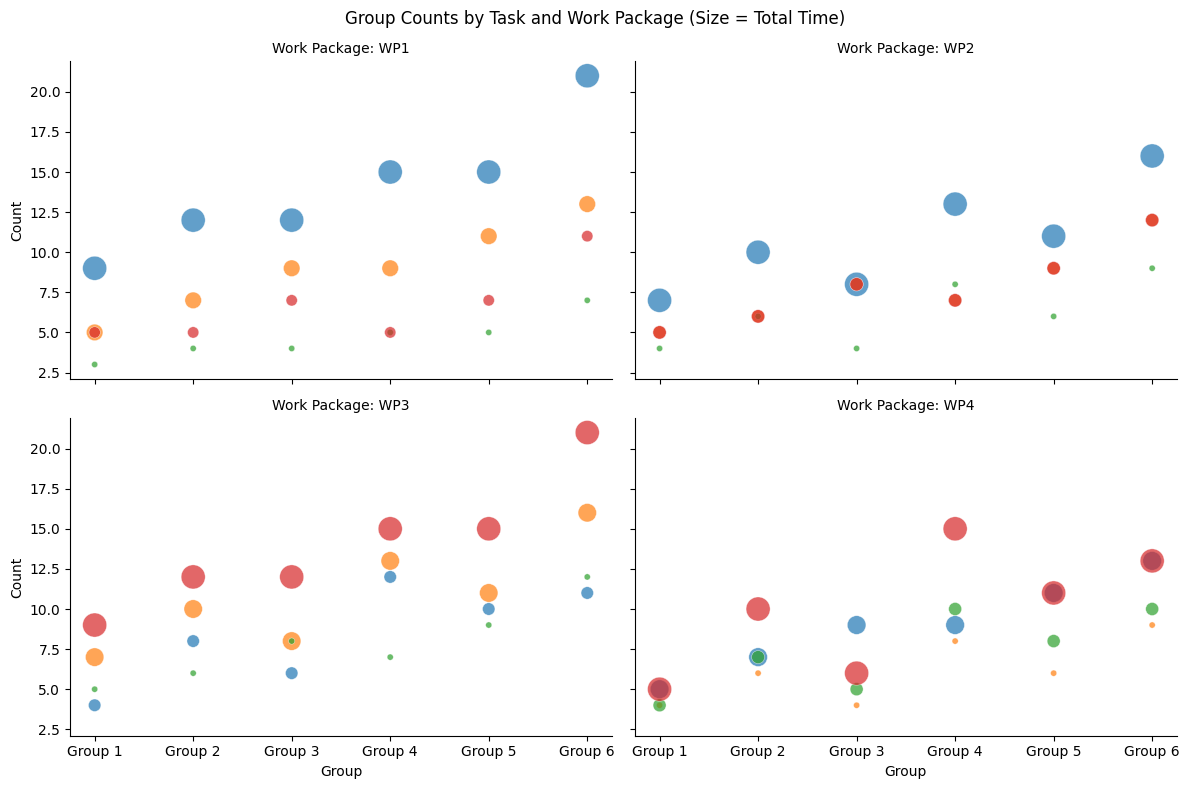

In [6]:
g = sns.FacetGrid(df_long, col="Work Package", col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(
    sns.scatterplot,
    x="Group",
    y="Count",
    size="Total Time",
    hue="Task",
    palette="tab10",
    sizes=(20, 300),
    alpha=0.7,
    legend=False
)

g.set_titles("Work Package: {col_name}")
g.set_axis_labels("Group", "Count")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Group Counts by Task and Work Package (Size = Total Time)")
plt.tight_layout()
plt.show()

## OLS Approach

In [3]:


# Fit linear regression model
model = LinearRegression()
model.fit(interaction_features, y)

# Create a MultiIndex for coefficients
coefficients = pd.Series(model.coef_, index=interaction_features.columns)
coefficients.index = coefficients.index.str.split(":", expand=True)
coefficients.index.names = ["Group", "Task"]

# Reshape into a readable DataFrame: rows = Task, columns = Group
coef_matrix = coefficients.unstack(level="Group")

# Print or inspect the result
print(coef_matrix)


Group    Group 1   Group 2   Group 3   Group 4   Group 5   Group 6
Task                                                              
Task 1  1.308477  2.808240  1.166642  4.308003  2.666405  3.295918
Task 2  1.918545  3.144050  0.571495  4.369556  1.797000  3.776317
Task 3  2.139716  3.018465  0.771107  3.897214  1.649856  4.034502
Task 4  0.477499  2.402612  1.877859  4.327724  3.802971  2.617734


## Confidence Intervals

In [9]:
import pandas as pd
import statsmodels.api as sm

# Assuming X and y are already defined (from your group-task interaction matrix)
# and both are NumPy arrays or DataFrames of matching length

# Add intercept (constant) to the design matrix
X_with_const = sm.add_constant(X)  # adds a column of 1s for the intercept

# Fit the model
model = sm.OLS(y, X_with_const).fit()

# View full summary
print(model.summary())

# Extract confidence intervals
conf_int = model.conf_int(alpha=0.05)  # 95% CI
conf_int.columns = ['Lower Bound', 'Upper Bound']

# Attach variable names
conf_int.index = ['Intercept'] + list(X.columns)

print('_____________________')
print('Confidence Intervals')
print(conf_int)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     803.5
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           6.43e-05
Time:                        14:39:52   Log-Likelihood:                -18.440
No. Observations:                  16   AIC:                             62.88
Df Residuals:                       3   BIC:                             72.92
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3897      2.461     -0.

/home/criley/working_dir/coefficient_estimation/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


### Results Eval

The concern is here that the confidence intervals are showing negative values. This isn't possible in this case. Could use non-negative linear regression. OR optimiser (below)

Additionally, if there are issues in the data, and things like collinearity may want to consider Ridge Regression.

## Optimiser Approach

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Set up interaction features
group_cols = [col for col in df.columns if col.startswith("Group")]
tasks = df['Task'].unique()

# Create column names for each (Group, Task) pair
columns = [f"{group}:{task}" for group in group_cols for task in tasks]
X = pd.DataFrame(0, index=df.index, columns=columns)

# Fill the interaction matrix
for idx, row in df.iterrows():
    for group in group_cols:
        col = f"{group}:{row['Task']}"
        X.at[idx, col] = row[group]

# Target variable
y = df["Total Time"].values
X_np = X.values
num_weights = X_np.shape[1]

# Define loss function (squared error)
def loss_fn(w):
    return np.sum((X_np @ w - y) ** 2)

# Optional: include gradient (not required, but speeds things up)
def grad_fn(w):
    return 2 * X_np.T @ (X_np @ w - y)

# Initial guess (e.g., small positive values)
w0 = np.ones(num_weights)

# Constraint: weights must be non-negative
bounds = [(0, None)] * num_weights

# Minimize
result = minimize(
    loss_fn,
    w0,
    method='L-BFGS-B',
    jac=grad_fn,
    bounds=bounds,
    options={'disp': True}
)

# Extract weights and reshape
weights = pd.Series(result.x, index=columns)
weights.index = weights.index.str.split(":", expand=True)
weights.index.names = ["Group", "Task"]
coef_matrix = weights.unstack(level="Group")

# Show result
print(coef_matrix)


Group    Group 1   Group 2   Group 3   Group 4   Group 5   Group 6
Task                                                              
Task 1  1.730540  3.008301  1.354784  4.286062  2.632545  2.912082
Task 2  2.306574  3.338050  0.765511  4.369526  1.796987  3.358355
Task 3  2.492325  3.196006  0.988854  3.899688  1.692536  3.584755
Task 4  0.913779  2.621123  2.031178  4.328466  3.738522  2.239930


## Testing the effect of varying initial values. 

Whilst the objective function is convex here, you may still finish optimisation early by hitting inflexion points. So test the solution by varying the initial guesses.

In [10]:
for seed in [0, 42, 99]:
    np.random.seed(seed)
    w0 = np.abs(np.random.randn(X.shape[1]))  # random non-negative init

    result = minimize(
        lambda w: np.sum((X @ w - y) ** 2),
        w0,
        method="L-BFGS-B",
        bounds=[(0, None)] * X.shape[1]
    )

    print(f"Seed {seed} → Objective: {result.fun:.2f}")

Seed 0 → Objective: 9.47
Seed 42 → Objective: 9.47
Seed 99 → Objective: 9.47


## Uncertainty

To determine the 'confidence intervals' in the results determined using optimisation, can use simulation based approached to model uncertainty in the inputs, by varying the independent variable.

Use Monte Carlo simulation and add Gaussian noise to y.
Simulate 50 times. 

In [12]:

import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Assume X (design matrix), y (target), and bounds are defined
# Initial weight guess
w0 = np.ones(X.shape[1])
bounds = [(0, None)] * X.shape[1]

# Storage for all weight estimates
n_simulations = 50
all_weights = []

for i in range(n_simulations):
    # Add small Gaussian noise to y
    y_sim = y + np.random.normal(0, 1.0, size=len(y))

    # Re-fit with simulated y
    result = minimize(
        lambda w: np.sum((X @ w - y_sim) ** 2),
        w0,
        method="L-BFGS-B",
        bounds=bounds
    )
    all_weights.append(result.x)

# Convert to DataFrame
weights_sim = pd.DataFrame(all_weights, columns=X.columns)

# Calculate 95% confidence intervals
ci_lower = weights_sim.quantile(0.025)
ci_upper = weights_sim.quantile(0.975)

# Combine into a summary
ci_summary = pd.DataFrame({
    "Lower Bound (2.5%)": ci_lower,
    "Upper Bound (97.5%)": ci_upper,
    "Mean": weights_sim.mean()
})

print(ci_summary)


                Lower Bound (2.5%)  Upper Bound (97.5%)      Mean
Group 1:Task 1            1.424395             2.162293  1.773589
Group 1:Task 2            1.448224             3.142855  2.291011
Group 1:Task 3            1.649151             3.726028  2.536936
Group 1:Task 4            0.085118             1.492147  0.865124
Group 2:Task 1            2.808691             3.271411  3.025089
Group 2:Task 2            3.196556             3.486128  3.350183
Group 2:Task 3            2.887599             3.497672  3.204647
Group 2:Task 4            2.240795             2.913443  2.599008
Group 3:Task 1            0.868951             1.712710  1.328855
Group 3:Task 2            0.480832             1.013251  0.740172
Group 3:Task 3            0.478070             1.524328  0.976411
Group 3:Task 4            1.509460             2.671445  2.072040
Group 4:Task 1            3.790157             4.610878  4.276585
Group 4:Task 2            3.604401             5.205553  4.409355
Group 4:Ta

## What next

Now you have your estimates, you can use these values to determine the time for individual groups/ work packages